In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from matplotlib.ticker import MaxNLocator


In [19]:
# for testing
# mcfiles = ['../dsa_mc/testing.npy']

# for different center of mass energies
# rs_arr = ['55', '65', '75', '85', '95', '105', '115']
rs_arr = ['55', '95']
mcfiles = [f'../dsa_mc/roots_{rs}/roots_{rs}_100k.npy' for rs in rs_arr]

# for different replicas
# mcfiles = [
#     f'../dsa_mc/roots_95/roots_95_100k.npy',
#     f'../dsa_mc/roots_95_trial2/roots_95_100k_trial2.npy',
#     f'../dsa_mc/roots_95_trial3/roots_95_100k_trial3.npy'
#           ]


# mcfiles = ['../dsa_mc/roots_75/roots_75_100k.npy']
# mcfiles = ['../dsa_mc/roots_65/roots_65_100k.npy']
# mcfiles = ['../dsa_mc/roots_75/data/mc_data_0.npy']

columns = ['s', 'Q', 'x', 'delta', 'pT', 'z', 'y', 'phi_kp', 'phi_Dp', 
                                      'num_dsa', 'den_dsa', '<1>', '<cos(phi_kp)>', '<cos(phi_Dp)>', 
                                     '<cos(phi_Dp)cos(phi_kp)>', '<sin(phi_Dp)sin(phi_kp)>']



mc_df = {}
for ifile, mcfile in enumerate(mcfiles):
    mcdata = np.load(mcfile)
    
    mc_df[rs_arr[ifile]] = pd.DataFrame(mcdata, columns=columns)
    mc_df[rs_arr[ifile]]['t'] = np.abs(mc_df[rs_arr[ifile]]['delta'])**2

    # mc_df[f'trial {ifile}'] = pd.DataFrame(mcdata, columns=columns)
    # mc_df[f'trial {ifile}']['t'] = np.abs(mc_df[f'trial {ifile}']['delta'])**2



In [5]:
# mc_df['trial 2'].tail()

KeyError: 'trial 2'

In [21]:
# function to plot histograms

# setup plotting
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12  
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 16  
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"
%config InlineBackend.figure_format = 'retina'

labels = {
         'num_dsa': 'DSA',
         'den_dsa': 'Total',
         '<1>': r'$A_{LL}$',
         '<cos(phi_kp)>': r'$\langle \cos(\phi_{kp}) \rangle$',
         '<cos(phi_Dp)>': r'$\langle \cos(\phi_{\Delta p}) \rangle$',
         '<cos(phi_Dp)cos(phi_kp)>': r'$\langle \cos(\phi_{kp}) \cos(\phi_{\Delta p}) \rangle$',
         '<sin(phi_Dp)sin(phi_kp)>': r'$\langle \sin(\phi_{kp}) \sin(\phi_{\Delta p}) \rangle$'
         }

def plot_histogram(datasets, df, weights, constraints={}, **options):

    asp_ratio = 4/3
    psize = 5

    fig, ax = plt.subplots(1, 1, figsize=(asp_ratio*psize, psize))
        
    colors = ['black', 'red', 'blue', 'green', 'gray', 'orange', 'pink']
    linestyles = ['-', '-', '-', '-', '-', '-', '-']

    # lumi = options.get('lumi', 10) # total integrated luminosity in fb^-1
    # lumi *= options.get('efficiency', 1) # correct for detector efficiency

    lumis = [data['lumi'] for data in datasets]
    if len(set(lumis)) == 1: same_lumi = True
    else: same_lumi = False

    for idata, data in enumerate(datasets):
        for iw, weight in enumerate(weights): 

            no_label = False
            if len(datasets) > 1:
                if len(weights) > 1: raise ValueError('Should not plot multiple weights with multiple datasets')
                label = options.get('labels')[idata]
                ilab = idata
            
            elif len(weights) > 1:
                label = options.get('labels')[iw]
                ilab = iw
                    
            else:
                ilab = 0
                label = None

            # make data plot
            if options.get('rel_error'):
                ax.step(data[weight]['bin_centers'], data[weight]['rel_errors'], where='mid', linestyle=linestyles[ilab], color=colors[ilab], linewidth=1, label=label)
                ax.scatter(data[weight]['bin_centers'], data[weight]['rel_errors'], linestyle=linestyles[ilab], color=colors[ilab], linewidth=1)
            else:
                ax.errorbar(
                    data[weight]['bin_centers'], data[weight]['plot_counts'], yerr=data[weight]['total_errors'],
                    fmt=options.get('fmt', 'o'), 
                    capsize=3, elinewidth=0.8, capthick=0.5, color=colors[ilab],
                    label=label
                )
    
                ax.step(data[weight]['bin_centers'], data[weight]['plot_counts'], where='mid', linestyle=linestyles[ilab], color=colors[ilab], linewidth=1)

        # make info box for kinematics
        if same_lumi:
            info_text = fr'Integrated luminosity: ${lumis[0]}\,\, \mathrm{{fb}}^{{-1}}$' + '\n'
        else:
            info_text = ''
            
        if options.get('roots_label'):
            info_text += fr'$\sqrt{{s}} = {round(np.sqrt(df.iloc[0]['s']))}\,\, \mathrm{{GeV}}$' + '\n'
        else: 
            pass
        # info_text += '\nCuts:'

        for var in ['Q', 'x', 't', 'z']:
            low = df[var].min()
            high = df[var].max()
            
            if var == 'Q':
                info_text += fr'${var}^2 \, \in \,[{round(low**2,1)}, \, {round(high**2,1)}]\, \mathrm{{GeV^2}}$' + '\n'
            elif var == 't':
                info_text += fr'${var} \, \in \,  [{round(low,2)}, \, {round(high,2)}]\, \mathrm{{GeV}}^2$' + '\n'
            elif var == 'x':
                info_text += fr'${var} \, \in \, [{round(low,3)}, \, {round(high,3)}]$' + '\n'
            elif var == 'z':
                info_text += fr'${var} \, \in \, [{round(low,2)}, \, {round(high,2)}]$'

        if options.get('info_box'):
            if options.get('rel_error'):
                ax.text(
                    0.6, 0.05, info_text, 
                    transform=ax.transAxes,  
                    ha='left', va='bottom', 
                    fontsize=11, wrap=True, 
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.3, edgecolor='none')
                )
            else:
                ax.text(
                    0.05, 0.05, info_text, 
                    transform=ax.transAxes, 
                    ha='left', va='bottom', 
                    fontsize=11, wrap=True, 
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.3, edgecolor='none')
                )

        if len(weights) > 1 or len(datasets) > 1: ax.legend(frameon=False)

        # set plot info
        if options.get('y_limits'): ax.set_ylim(options.get('y_limits'))
        # ax.set_xlim(options.get('x_limits', [plot_bins[0], plot_bins[-1]]))
        ax.set_title(options.get('title', ''))
        ax.set_ylabel(options.get('y_label', ''), loc='top')
        ax.set_xlabel(options.get('x_label', ''), loc='right')
        ax.set_yscale(options.get('y_scale', 'linear'))
        ax.set_xscale(options.get('x_scale', 'linear'))
        # ax.tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
        ax.tick_params(which='both', direction="in", length=5, width=1)
        ax.grid(options.get('grid', False)) 
        ax.xaxis.set_major_locator(MaxNLocator(nbins=15))
        if options.get('zero_line', False): ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)
        if options.get('one_line', False): ax.axhline(y=1, color='gray', linestyle='--', linewidth=1)
        if options.get('min_pT_line', False) and plot_var == 'pT': 
            ax.axvline(x=1, color='gray', linestyle='--')
            ax.fill_betweenx(ax.get_ylim(), ax.get_xlim()[0], 1, color='gray', alpha=0.25)
        plt.tight_layout()
        if options.get('saveas'): 
            if 'DNS' in options.get('saveas'): 
                pass
            else:
                fig.savefig(options.get('saveas'), dpi=400, bbox_inches="tight")



def cut_data(df, var, weights, constraints={}, **options):

    lumi = options.get('lumi', 10) # total integrated luminosity in fb^-1
    lumi *= options.get('efficiency', 1) # correct for detector efficiency
        
    # get bins
    bins = options.get('bins')
    nbins = len(bins)
    bin_width = bins[1] - bins[0]

    # enforce constraints
    mask = pd.Series(True, index=df.index)
    for ivar, (low, high) in constraints.items(): mask &= df[ivar].between(low, high)
    fixed_df = df[mask]

    if fixed_df.empty:
        print('Error: cut data is empty - constraints are too strict')
        return

    for iw in weights: assert iw in list(df.columns), f'Error: option for weight {iw} not recognized'

    cut_data = {}
    # make plot data       
    for iw, weight in enumerate(weights):

        total_counts, plot_bins = np.histogram(fixed_df[var], bins=bins, weights=fixed_df['den_dsa'])
        plot_counts, _ = np.histogram(fixed_df[var], bins=bins, weights=fixed_df[weight])
        bin_centers = 0.5*(plot_bins[:-1]+plot_bins[1:])

        # ensure bins are properly averaged
        n_entries, _ = np.histogram(fixed_df[var], bins=bins)
        plot_counts = np.array([icount/(bin_width*ientry) if ientry != 0 else 0 for icount, ientry in zip(plot_counts, n_entries)])
        total_counts = np.array([icount/(bin_width*ientry) if ientry != 0 else 0 for icount, ientry in zip(total_counts, n_entries)])
        
        # errors are calculated for a given integrated luminosity (5% systematic error added per 1505.05783)
        if '<' in weight:
            stat_errors = np.array([np.sqrt((1+ic)/(lumi*tc)) if tc != 0 else 0 for ic, tc in zip(plot_counts, total_counts)])
        else:
            stat_errors = np.sqrt(total_counts/lumi)
        sys_errors = 0.05*np.abs(plot_counts)  
        total_errors = np.sqrt((stat_errors**2)+(sys_errors)**2)
        rel_errors = [ierror/np.abs(icount) if icount != 0 else 0 for icount, ierror in zip(plot_counts, total_errors)]

        cut_data[weight] = {}
        cut_data[weight]['bin_centers'] = bin_centers
        cut_data[weight]['plot_counts'] = plot_counts
        cut_data[weight]['total_errors'] = total_errors
        cut_data[weight]['rel_errors'] = rel_errors
    cut_data['lumi'] = lumi

    return cut_data, fixed_df



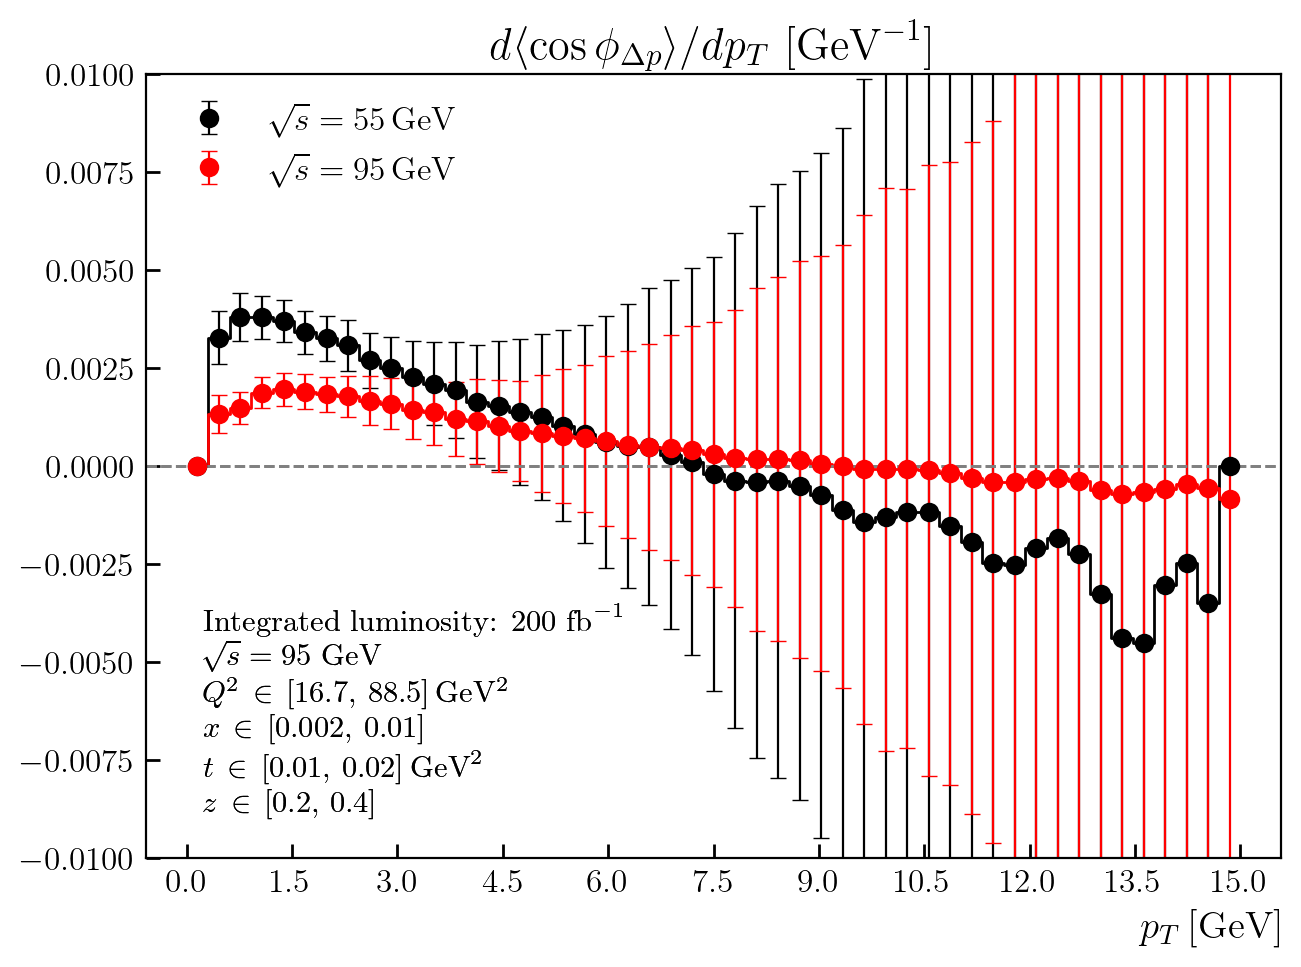

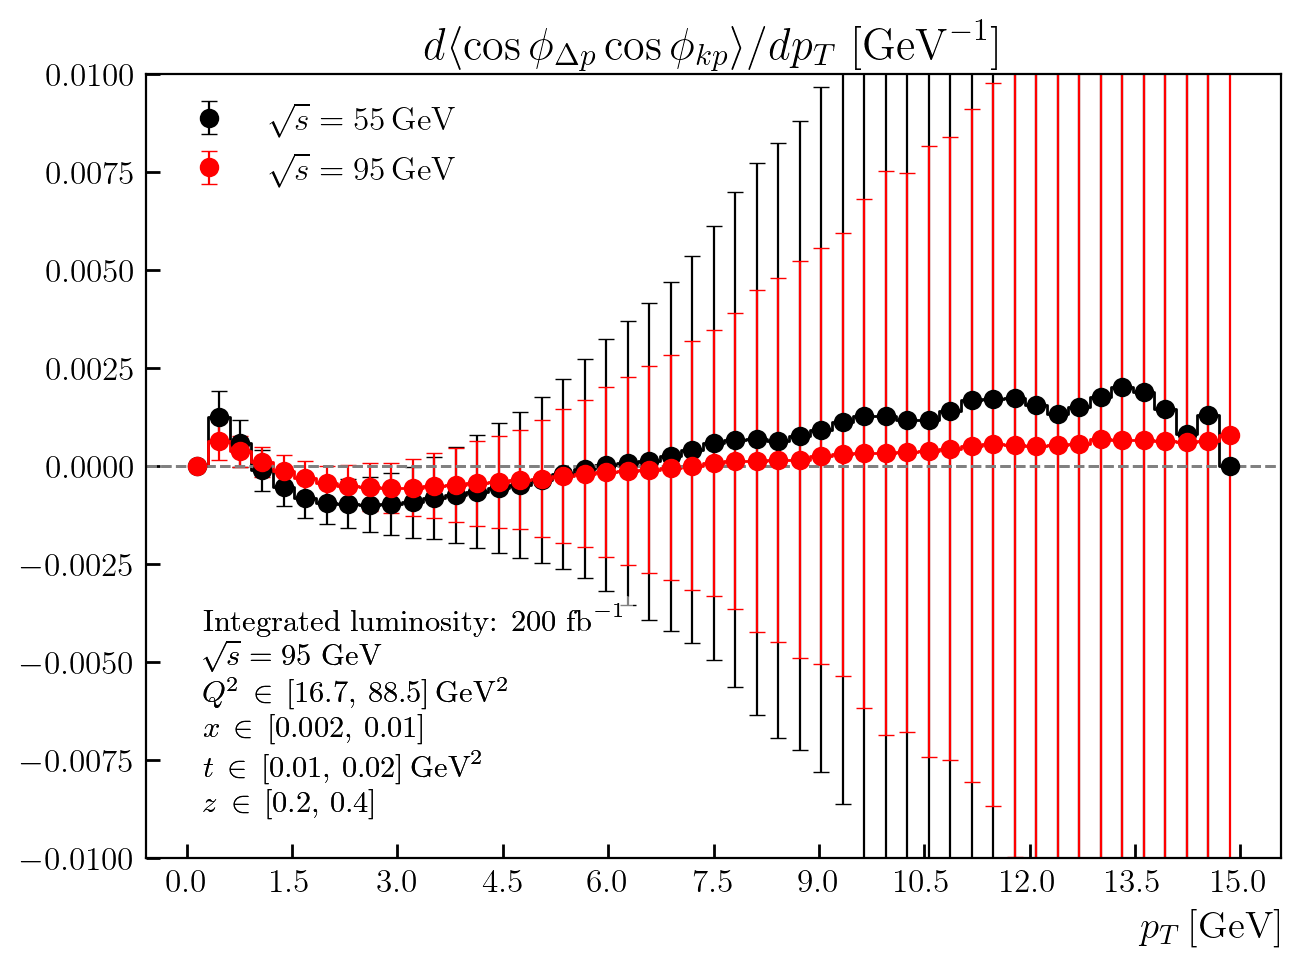

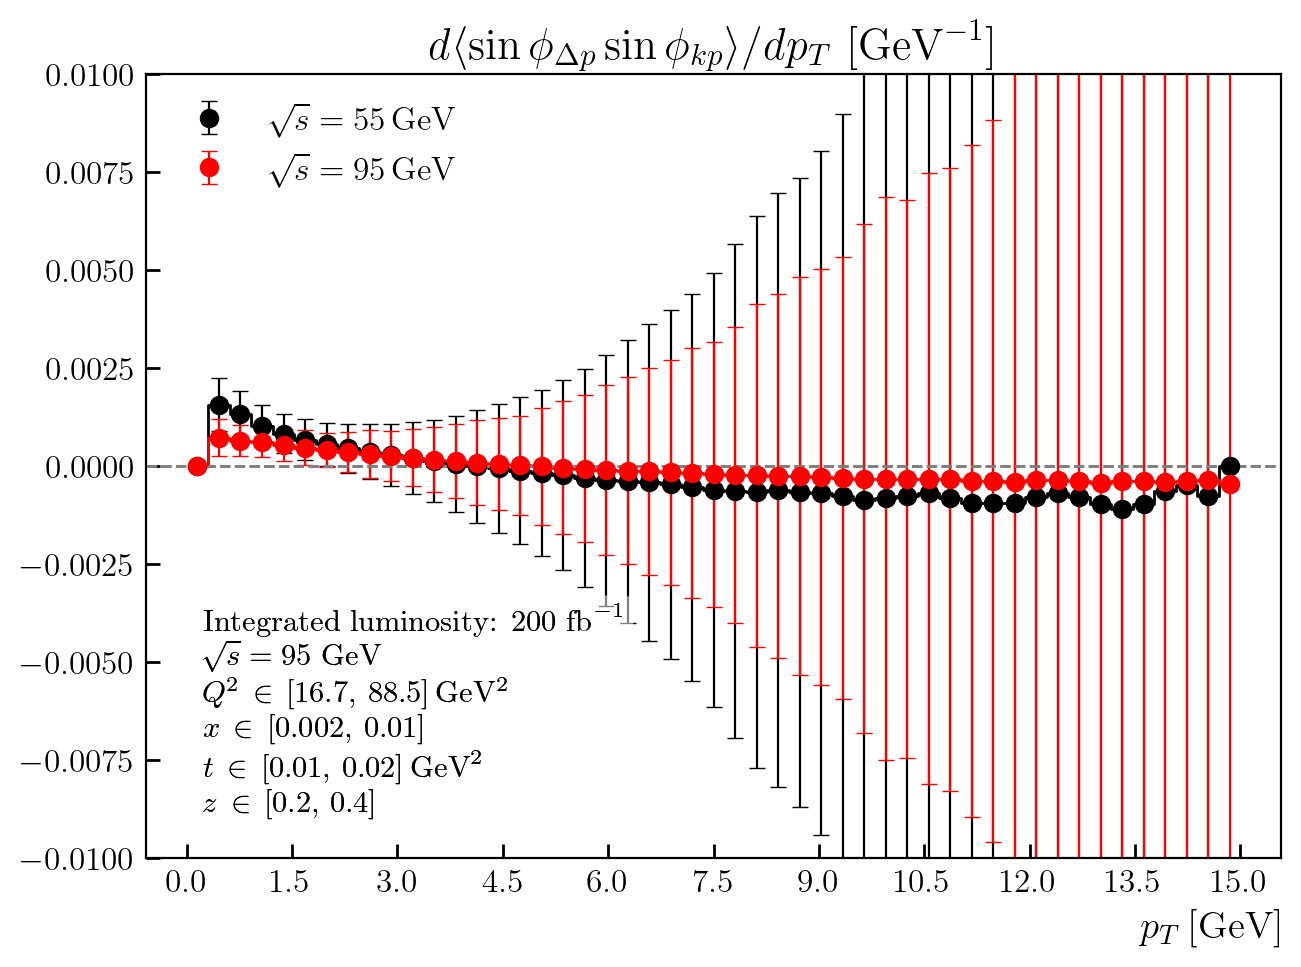

In [25]:
# plot relevant quantities 

Q_bins = np.linspace(6, 10.0, num=35)
pT_bins = np.linspace(0, 15.0, num=50)
phi_bins = [i/(2*np.pi) for i in range(15)]

lumi = 200
Q_min = 4.0
Q_max = 9.5
y_min = 0.4
y_max = 0.5
z_min = 0.2
z_max = 0.4
x_min = 0.00001
x_max = 0.01
t_min = 0.01
t_max = 0.02




# labels = [r'$d \langle \cos \phi_{kp} \, \cos \phi_{\Delta p} \rangle /dp_T \,\,[\mathrm{GeV}^{-1}]$', 
#           r'$\delta_{\mathrm{rel.}} d \langle  \cos \phi_{\Delta p} \rangle /dp_T $']

cuts = {
        # 'Q': [Q_min, Q_max],
        # 'pT': [2.5, 3.5]
        # 'y': [y_min, y_max],
        'z': [z_min, z_max],
        # 'x': [x_min, x_max],
        't': [t_min, t_max]
        }
cdata = []


# for different center of mass energies
labels = []
for irs, rs in enumerate(rs_arr): 
    # if rs not in ['55', '85', '115']: continue
    if rs not in ['55', '95']: continue

    labels.append(rf'$\sqrt{{s}} = {rs} \, \mathrm{{GeV}}$')
    tdata, cdf = cut_data(mc_df[rs], 'pT', ['<cos(phi_Dp)>','<cos(phi_Dp)cos(phi_kp)>', '<sin(phi_Dp)sin(phi_kp)>'], cuts, bins=pT_bins, lumi=lumi)
    cdata.append(tdata)
tag = 'roots'


# for different trials
# labels = []
# for irep in range(len(mcfiles)):
#     labels.append(rf'replica ${irep}$')
    
#     tdata, cdf = cut_data(mc_df[f'trial {irep}'], 'pT', ['<cos(phi_Dp)>','<cos(phi_Dp)cos(phi_kp)>', '<sin(phi_Dp)sin(phi_kp)>'], cuts, bins=pT_bins, lumi=lumi)
#     cdata.append(tdata)
# tag = 'trials'



plot_histogram(cdata, cdf, ['<cos(phi_Dp)>'], 
               lumi = lumi,
               labels = labels,
               efficiency = 1, 
               # y_scale='log', 
               # x_scale='log',
               # x_limits = [5, 11], 
               bins = pT_bins,
               y_limits = [-0.01, 0.01],
               # one_line = True,
               zero_line = True,
                # rel_error=True,
               info_box = True,
               roots_label=True,
               title=r'$d \langle  \cos \phi_{\Delta p} \rangle /dp_T \,\,[\mathrm{GeV}^{-1}]$', 
               # title=r'$\delta_{\mathrm{rel.}}  \langle  \cos \phi_{\Delta p}  \rangle $',
               x_label=r'$p_T\, [\mathrm{GeV}]$',
               saveas = f'plots/cos_{tag}.pdf'
              )


plot_histogram(cdata, cdf, ['<cos(phi_Dp)cos(phi_kp)>'], 
               lumi = lumi,
               labels = labels,
               efficiency = 1, 
               # y_scale='log', 
               # x_scale='log',
               # x_limits = [5, 11], 
               bins = pT_bins,
               y_limits = [-0.01, 0.01],
               # one_line = True,
               zero_line = True,
                # rel_error=True,
               info_box = True,
               roots_label=True,
               title=r'$d \langle  \cos \phi_{\Delta p} \cos \phi_{k p} \rangle /dp_T \,\,[\mathrm{GeV}^{-1}]$', 
               # title=r'$\delta_{\mathrm{rel.}} \langle   \cos \phi_{\Delta p} \cos \phi_{k p}  \rangle $',
               x_label=r'$p_T\, [\mathrm{GeV}]$',
               saveas = f'plots/coscos_{tag}.pdf'
              )



plot_histogram(cdata, cdf, ['<sin(phi_Dp)sin(phi_kp)>'], 
               lumi = lumi,
               labels = labels,
               efficiency = 1, 
               # y_scale='log', 
               # x_scale='log',
               # x_limits = [5, 11], 
               bins = pT_bins,
               y_limits = [-0.01, 0.01],
               # one_line = True,
               zero_line = True,
                # rel_error=True,
               info_box = True,
               roots_label=True,
               title=r'$d \langle  \sin \phi_{\Delta p} \sin \phi_{k p} \rangle /dp_T \,\,[\mathrm{GeV}^{-1}]$', 
               # title=r'$\delta_{\mathrm{rel.}}  \langle  \sin \phi_{\Delta p} \sin \phi_{k p}  \rangle $',
               x_label=r'$p_T\, [\mathrm{GeV}]$',
               saveas = f'plots/sinsin_{tag}.pdf'
              )


